### Static Bayesian Optimization: 
- initial training on burnin points
- use acquisition function to guide next sampling
- re-optimize the model
- plot and visualize before and after
- loop and use acquistion function for up to 100 samples. 


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy

In [2]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [3]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        CA1_df = pd.read_csv(path)

        # Get frequency and amplitudes
        U1 = CA1_df.iloc[:,  0:2]
        # Get the coordinate of pre stimulation gamma 
        X0_coords = np.arange(33,52)

        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
        X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        X0_psd = X0_psd*1e10 # Need values >0 for GP model
        N_trials = np.size(X0_psd, axis=0)
        lower_bound = np.min(U1, axis=0)
        upper_bound = np.max(U1, axis=0)
        # sum of post stimulation gamma         
        X1_coords = np.arange(133,152)
        X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
        X1 = np.array(X1)
        X1 =X1[:, np.newaxis] # reshape
        X1 = X1*1e10 # bring to >0 range        
       
        return X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials;
    
    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, U1, X0_psd, X1, kernel, slice_dim, ylabel):
       
        # input_data
        U1_X0 = U1.join(X0_psd)
        
        # create simple GP model
        m = GPy.models.GPRegression(U1,X1,kernel)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

        display(canvas);
        
        # Min and Max of State
        
        # Number of trials
        
        
        return U1_X0, X1, m; 
    
    
    #Sample Function
    def sample(self,testX, m):

        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        state_est = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
        simY, simMse = m.predict(testX)

        # print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # # posteriorTestY
        # print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        # print(np.shape(simY),'\n', np.shape(simMse))

        return state_est, simY, simMse;
    
    # Acquisition Function
    def acquisition_function(self, simY, simMse, nu, t):
        # Upper Confidence Bound implementation
        #  if d=2 and delta=2
        tau_t = 2*np.log(t**2*(np.pi)**2/6)
        
        ucb = simY+(np.sqrt(nu*tau_t))*simMse
        
        return ucb
    
    def transition_state(self, U1, X0_psd, state_est, testX):
        state_data_dr = X0_psd
        current_state = np.append(X0_psd, state_est[:,0:1], axis=0)
#         testX_shape_row, testX_shape_col = np.shape(testX)
        
#         current_state = np.empty(())
        
        return current_state
        
    

In [4]:
model = state_dr_gp()

In [5]:
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

In [6]:
print('Sum preStim gamma are: \n', X0_psd, '\n','freq and amplitude used are: \n', U1[0:4])

Sum preStim gamma are: 
      sum_preStim_gamma
0             3.266571
1             2.425945
2             3.117866
3             2.868627
4             3.521665
..                 ...
379           1.268502
380           1.239859
381           1.880050
382           1.199899
383           1.343332

[384 rows x 1 columns] 
 freq and amplitude used are: 
    Stim_1  Stim_2
0      17      30
1      42      40
2      35      30
3      23      50


In [7]:
U1.loc[0:10, 'Stim_1']

0     17
1     42
2     35
3     23
4     42
5     35
6     11
7      7
8     17
9     11
10    17
Name: Stim_1, dtype: int64

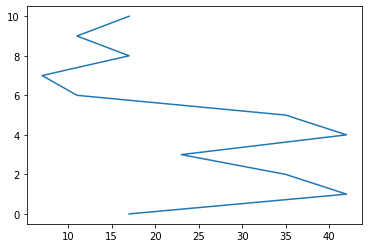

In [8]:
plt.plot(U1.loc[0:10,'Stim_1'], np.arange(0,11));

In [9]:
print(np.shape(U1), np.shape(X0_psd))

(384, 2) (384, 1)


In [10]:
# chose the first 10 for burn-in/initial training of the model
U1_init = U1.loc[0:19,:]
X0_psd_init = X0_psd.loc[0:19]
X1_init = X1[0:20,:]
print('Sum preStim gamma are: \n', X0_psd_init, '\n','freq and amplitude used are: \n', U1_init)
print('sum postStim gamma are: \n', X1_init)

Sum preStim gamma are: 
     sum_preStim_gamma
0            3.266571
1            2.425945
2            3.117866
3            2.868627
4            3.521665
5            1.384478
6            1.420178
7            1.533292
8            2.019014
9            2.231953
10           2.347957
11           2.131811
12           1.934441
13           2.512154
14           4.690816
15           2.645199
16           6.401632
17           1.984354
18           3.580944
19           2.032816 
 freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20
sum postStim gamma are: 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010

In [11]:
# input_data
U1_X0_init = U1_init.join(X0_psd_init)

#### initial training

In [12]:
ker_BaO = GPy.kern.Matern52(input_dim=2, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [13]:
slice_dim = 1
ylabel='Predicted Gamma'

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x2c997aae3d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2c997aae6d0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0005   3.497163e+02   8.940937e+02 
    00s08  0012   8.539591e+01   9.174011e-02 
    00s19  0025   3.191608e+06   5.082507e+12 
    00s34  0053   6.946105e+01   2.090506e-10 
Runtime:     00s34
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x2c998cb42b0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2c998c90ee0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x2c998df1490>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x2c998df18b0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x2c998df18e0>]}

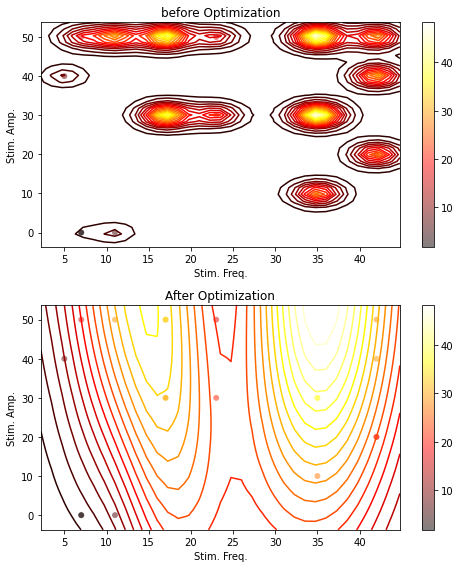

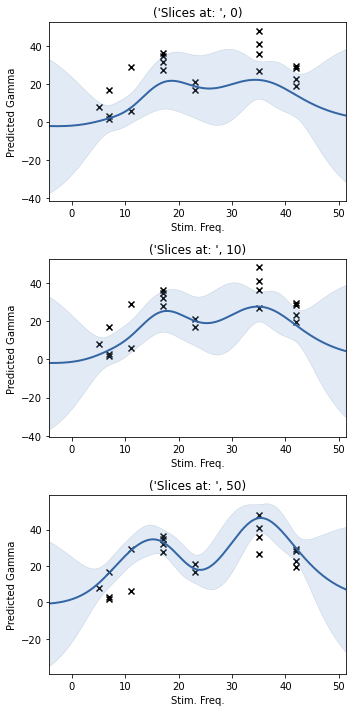

In [14]:
x_BaO, y_BaO, trained_model_BaO = model.initialize_data_dr_sim(U1_init, X0_psd_init, X1_init, ker_BaO, slice_dim, ylabel)

#### use the acquisition function to guide the next freq to optimize at

In [15]:
sampling_freq = np.empty((10))
sampling_freq[:] = 35
sampling_amp = np.empty((10))
sampling_amp[:] = 40
print(np.shape(sampling_freq), np.shape(sampling_amp))

testX_BaO = np.array([sampling_freq, sampling_amp])
print(np.shape(testX_BaO))
testX = np.transpose(testX_BaO)
print(testX_BaO[0:2, 0:1])

(10,) (10,)
(2, 10)
[[35.]
 [40.]]


In [16]:
state_est_BaO = np.empty((10,1))
simY_BaO = np.empty((10, 1))
simMse_BaO = np.empty((10, 1))

for i in range(9):
        # print(i)
    state_est_BaO[i:i+2, 0], simY_BaO[i:i+2,0:1], simMse_BaO[i:i+2,0:1] = model.sample(testX_BaO, trained_model_BaO);

print("mean is: \n",simY_BaO[0, 0],"\n\n Variance is: \n", simMse_BaO[0, 0])
# posteriorTestY
print(np.shape(state_est_BaO),'\n',state_est_BaO[0:10, 0:2])
print(np.shape(simY_BaO),'\n', np.shape(simMse_BaO))

mean is: 
 41.03700797059547 

 Variance is: 
 12.19036043080962
(10, 1) 
 [[39.73511609]
 [38.05173941]
 [37.46741654]
 [39.22239762]
 [45.21165395]
 [40.1172402 ]
 [43.06910532]
 [42.85216377]
 [44.59286133]
 [41.32069064]]
(10, 1) 
 (10, 1)


In [17]:
# inspecting the inputs to acquistion_function:
print(np.shape(testX_BaO))
print(testX_BaO[:,0:3])

# Mean and variance after initial training using "burn-in" points:
print("mean is: \n",simY_BaO[0, 0],"\n\n Variance is: \n", simMse_BaO[0, 0])

nu = 0.1
print("nu set at: ", nu)
# t = the sample we are on 

(2, 10)
[[35. 35. 35.]
 [40. 40. 40.]]
mean is: 
 41.03700797059547 

 Variance is: 
 12.19036043080962
nu set at:  0.1


In [18]:
ucb = np.empty((1))
freq_choices = [5,7,11,17, 23, 35, 42]

ucb= model.acquisition_function(simY_BaO, simMse_BaO, nu, 1)
# print(np.shape(ucb))
median_ucb = np.median(ucb)
next_freq_idx = abs(median_ucb-freq_choices).argmin()
    
print(median_ucb)
print(next_freq_idx, 'next freq is: ', freq_choices[6])

44.88306302542917
6 next freq is:  42


In [19]:
np.shape(U1)[0]
print(U1.loc[20,'Stim_1'])

11


In [29]:
# From sample #20next_idx_to_optimize, pick 20 samples in U1, X0 and X1 such that the freq = 42
next_idx_to_optimize = []

for idx in range(20, np.shape(U1)[0]):
    if U1.loc[idx,'Stim_1']==freq_choices[next_freq_idx]:
        # print(idx)
        next_idx_to_optimize.append(idx)
        if np.size(next_idx_to_optimize)>20:
            break
        
print(next_idx_to_optimize)

[44, 52, 59, 62, 84, 85, 87, 108, 121, 122, 123, 125, 131, 144, 147, 163, 164, 180, 185, 188, 202]


In [55]:
U1_next = U1.loc[next_idx_to_optimize,:]
X0_psd_next = X0_psd.loc[next_idx_to_optimize]
X1_next = X1[next_idx_to_optimize,:]
print('Sum preStim gamma are: \n', X0_psd_next, '\n','freq and amplitude used are: \n', U1_next)
print('sum postStim gamma are: \n', X1_next, '\n', np.shape(X1_next))

Sum preStim gamma are: 
      sum_preStim_gamma
44            2.420078
52            2.686982
59            4.842446
62            4.029272
84            2.863288
85            1.967909
87            2.094835
108           1.413476
121           2.704110
122           1.524605
123           1.755103
125           4.995416
131           1.392225
144           1.462022
147           1.818871
163           1.736952
164           0.821572
180           1.469976
185           2.198201
188           2.637775
202           1.930506 
 freq and amplitude used are: 
      Stim_1  Stim_2
44       42      40
52       42      40
59       42      50
62       42      20
84       42      10
85       42      40
87       42      40
108      42      10
121      42      50
122      42      50
123      42      30
125      42      20
131      42       0
144      42       0
147      42      50
163      42      40
164      42      10
180      42      30
185      42      10
188      42      30
202      42     

#### Plot before and after optimization 

In [56]:
# Combine initial samples with next samples
U1_combo = pd.concat([U1_init,U1_next])
X0_psd_combo = pd.concat([X0_psd_init, X0_psd_next])
X1_combo = np.append(X1_init, X1_next, axis=0)

print(np.shape(X1_combo))
print(U1_combo, '\n', X0_psd_combo.head(), '\n', X1_combo[0:4])

(41, 1)
     Stim_1  Stim_2
0        17      30
1        42      40
2        35      30
3        23      50
4        42      50
5        35      50
6        11       0
7         7       0
8        17      30
9        11      50
10       17      50
11       35      30
12        5      40
13       42      20
14       23      30
15        7      50
16       35      10
17       17      50
18        7       0
19       42      20
44       42      40
52       42      40
59       42      50
62       42      20
84       42      10
85       42      40
87       42      40
108      42      10
121      42      50
122      42      50
123      42      30
125      42      20
131      42       0
144      42       0
147      42      50
163      42      40
164      42      10
180      42      30
185      42      10
188      42      30
202      42      40 
    sum_preStim_gamma
0           3.266571
1           2.425945
2           3.117866
3           2.868627
4           3.521665 
 [[36.44022473]
 [29.52

In [53]:
U1_combo.reset_index()
U1_combo=U1_combo[['Stim_1', 'Stim_2']]
U1_combo.head()

X0_psd_combo.reset_index()
X0_psd_combo= X0_psd_combo[['sum_preStim_gamma']]
X0_psd_combo.head()


,sum_preStim_gamma
0,3.266571
1,2.425945
2,3.117866
3,2.868627
4,3.521665


 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x2c9a263bbe0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2c9a2657e20>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0004   1.279581e+02   1.579098e-02 
    00s07  0010   1.279292e+02   8.232996e-07 
    00s10  0014   1.279291e+02   1.689247e-06 
    00s18  0026   1.279271e+02   2.753340e-05    00s18  0025   1.279274e+02   1.328575e-04 
    00s22  0032   1.279271e+02   1.261568e-08 
Runtime:     00s22
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x2c9a25d9c10>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2c9a25e2880>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x2c9a38ea7c0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x2c9a38ead00>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x2c9a38dc790>]}

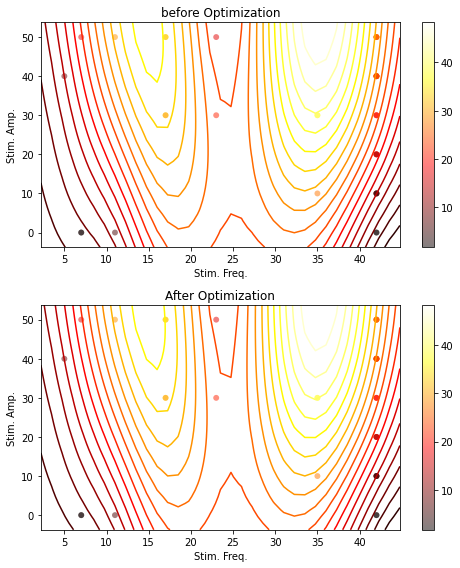

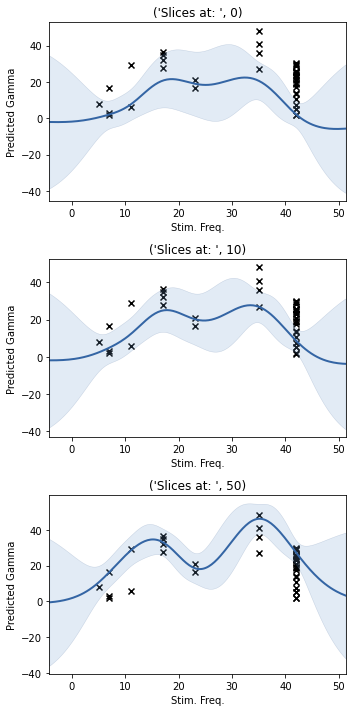

In [57]:
x_BaO, y_BaO, trained_model_BaO = model.initialize_data_dr_sim(U1_combo, X0_psd_combo, X1_combo, ker_BaO, slice_dim, ylabel)

### Normal Basian Optimization: training a model and sampling

sampling_freq = np.empty((100))
sampling_freq[:] = 35
sampling_amp = np.empty((100))
sampling_amp[:] = 40
print(np.shape(sampling_freq), np.shape(sampling_amp))

In [11]:
testX_BaO = np.array([sampling_freq, sampling_amp])
print(np.shape(testX_BaO))
testX = np.transpose(testX_BaO)
print(testX_BaO[0:2, 0:1])


(2, 100)
[[35.]
 [40.]]


#### Sampling

In [14]:
print(np.shape(testX_BaO))
print(testX_BaO[0:3,:])


(2, 100)
[[35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
  35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
  35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
  35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
  35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
  35. 35. 35. 35. 35. 35. 35. 35. 35. 35.]
 [40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.
  40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.
  40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.
  40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.
  40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.
  40. 40. 40. 40. 40. 40. 40. 40. 40. 40.]]


In [28]:
state_est_BaO = np.empty((100, 30))
simY_BaO = np.empty((100, 30))
simMse_BaO = np.empty((100, 30))

# 30 simulation of 100 sample points

for j in range(30):
    
    for i in range(99):
        # print(i)
        state_est_BaO[i:i+2, j], simY_BaO[i:i+2, j:j+1], simMse_BaO[i:i+2, j:j+1] = model.sample(testX_BaO, trained_model_BaO);

print("mean is: \n",simY_BaO[0, 0],"\n\n Variance is: \n", simMse_BaO[0, 0])
# posteriorTestY
print(np.shape(state_est_BaO),'\n',state_est_BaO[0:10, 0:2])
print(np.shape(simY_BaO),'\n', np.shape(simMse_BaO))

mean is: 
 24.19432791732015 

 Variance is: 
 15.739941709037309
(100, 30) 
 [[22.47545182 26.06839357]
 [24.40112632 23.1166395 ]
 [26.31122143 19.37040359]
 [22.85298132 19.68224337]
 [25.84106608 23.53885302]
 [21.58428497 19.42724479]
 [24.04706191 24.08576969]
 [27.18315243 24.46610678]
 [30.34663563 26.78622271]
 [24.56644977 25.83519027]]
(100, 30) 
 (100, 30)


In [29]:
print(testX_BaO[:,0:3])
print(np.shape(X0_psd))
print(np.shape(state_est_BaO[:,0:1]))

[[42. 42. 42.]
 [40. 40. 40.]]
(384, 1)
(100, 1)


In [30]:
current_state = np.append(X0_psd, state_est_BaO[:,0:1], axis=0)
print(np.shape(current_state), '\n', current_state[0:3, :])

(484, 1) 
 [[3.26657078]
 [2.42594512]
 [3.11786587]]


In [31]:
hill_state_est_BaO = np.empty((100, 30))
min_state_est_BaO = np.min(state_est_BaO,axis=0)
print(min_state_est_BaO[0])
max_state_est_BaO = np.max(state_est_BaO, axis=0)
print(max_state_est_BaO[0])
# step_size = np.round((max_posteriorTestY_BaO-min_posteriorTestY_BaO)/50,decimals=3)
print(step_size)
for i in range(30):
    hill_state_est_BaO[0:50,i] = np.linspace(min_state_est_BaO[i], max_state_est_BaO[i], 50)
    hill_state_est_BaO[50:100,i] = np.linspace(max_state_est_BaO[i],min_state_est_BaO[i], 50)
print(hill_state_est_BaO[0:50,1])

17.12646628756232
31.484254618019207
0.20370658621298587
[15.69263112 16.01032882 16.32802653 16.64572423 16.96342194 17.28111964
 17.59881734 17.91651505 18.23421275 18.55191045 18.86960816 19.18730586
 19.50500357 19.82270127 20.14039897 20.45809668 20.77579438 21.09349208
 21.41118979 21.72888749 22.0465852  22.3642829  22.6819806  22.99967831
 23.31737601 23.63507371 23.95277142 24.27046912 24.58816683 24.90586453
 25.22356223 25.54125994 25.85895764 26.17665534 26.49435305 26.81205075
 27.12974846 27.44744616 27.76514386 28.08284157 28.40053927 28.71823697
 29.03593468 29.35363238 29.67133009 29.98902779 30.30672549 30.6244232
 30.9421209  31.2598186 ]


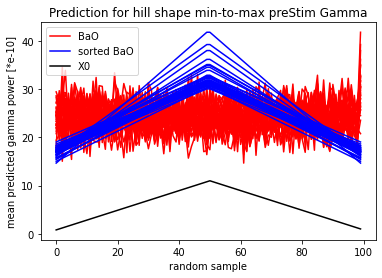

In [32]:
FIG, ax = plt.subplots()
a = plt.plot(state_est_BaO, 'r-')
b = plt.plot(hill_state_est_BaO, 'b-')
c = plt.plot(hill_sum_preStim_gamma, 'k-')
plt.ylabel('mean predicted gamma power [*e-10]')
plt.xlabel('random sample')
plt.title('Prediction for hill shape min-to-max preStim Gamma')
plt.legend([a[0],b[0],c[0]],['BaO','sorted BaO','X0']) #'Mean','+MSE', '-MSE', 
plt.show()

#### Acquisition Function: Using Upper Conficence Bound to guide sampling and re-optimizing the model

In [22]:
# inspecting the inputs to acquistion_function:
print(np.shape(testX_BaO))
print(testX_BaO[:,0:3])

# Mean and variance after initial training using "burn-in" points:
print("mean is: \n",simY_BaO[0, 0],"\n\n Variance is: \n", simMse_BaO[0, 0])

nu = 0.1
print("nu set at: ", nu)
# t = the sample we are on 

(2, 100)
[[35. 35. 35.]
 [40. 40. 40.]]
mean is: 
 37.21769353528373 

 Variance is: 
 15.740497567909214
nu set at:  0.1


In [23]:
ucb = np.empty((100,30))
freq_choices = [5,7,11,17, 23, 35, 42]

for s in range(100):
    if s>30:
        ucb[:,] = model.acquisition_function(simY_BaO, simMse_BaO, nu, s)
        # print(np.shape(ucb))
    median_ucb = np.median(ucb)
    next_freq_idx = abs(median_ucb-freq_choices).argmin()
    
print(ucb[0,0:3])
print(np.median(ucb))
# TODO: Next step is to sample at the ucb freq and re-optimize model         

[59.12803645 59.12803645 59.12803645]
3.537927958556302e+70


In [24]:
# choose the freq closest to UCB
freq_choices = [5,7,11,17, 23, 35, 42]
median_ucb = np.median(ucb)
next_freq_idx = abs(median_ucb-freq_choices).argmin()
print(next_freq_idx, 'next freq is: ', freq_choices[6])


0 next freq is:  42


In [25]:
testX_BaO[0,:] = freq_choices[6]
print(testX_BaO[:,0:3])


[[42. 42. 42.]
 [40. 40. 40.]]


In [26]:
print(np.arange(11,21))

[11 12 13 14 15 16 17 18 19 20]


In [27]:
for j in range(30):
    
    for i in np.arange(11,21):
        # print(i)
        state_est_BaO[i:i+2, j], simY_BaO[i:i+2, j:j+1], simMse_BaO[i:i+2, j:j+1] = model.sample(testX_BaO, trained_model_BaO);

print("mean is: \n",simY_BaO[0, 0],"\n\n Variance is: \n", simMse_BaO[0, 0])
# posteriorTestY
print(np.shape(state_est_BaO),'\n',state_est_BaO[0:10, 0:2])
print(np.shape(simY_BaO),'\n', np.shape(simMse_BaO))

mean is: 
 37.21769353528373 

 Variance is: 
 15.740497567909214
(100, 30) 
 [[39.95556794 41.14652916]
 [38.22599534 38.45339785]
 [38.02432525 36.30652346]
 [35.05036959 39.26564908]
 [36.93733003 42.77250764]
 [36.04735686 37.60402734]
 [39.65848004 34.59779262]
 [43.88989403 40.98898387]
 [36.93871509 43.16423551]
 [39.76073497 37.66229122]]
(100, 30) 
 (100, 30)


### State Dependent Basian Optimization: training a model and sampling

In [44]:
#GP model

# define kernel
kernel_SDBO = GPy.kern.Matern52(input_dim=3, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(3)
slice_dim_SDBO = 2
ylabel_SDBO = 'Stim. Amp.'

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1aa8ce9fac0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1aa8d8455b0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s14  0002   3.186270e+03   3.204701e+05 
    02s20  0028   1.111458e+03   1.992603e-02 
    02s84  0034   1.111442e+03   3.171993e-09 
Runtime:     02s84
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1aa8c917850>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1aa8d852bb0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1aa8b987a60>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1aa8b966880>]}

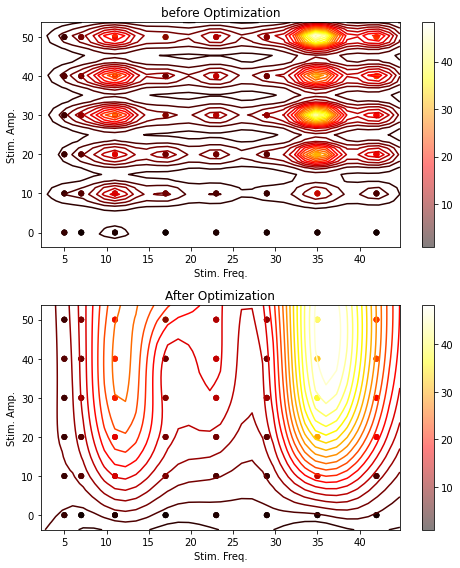

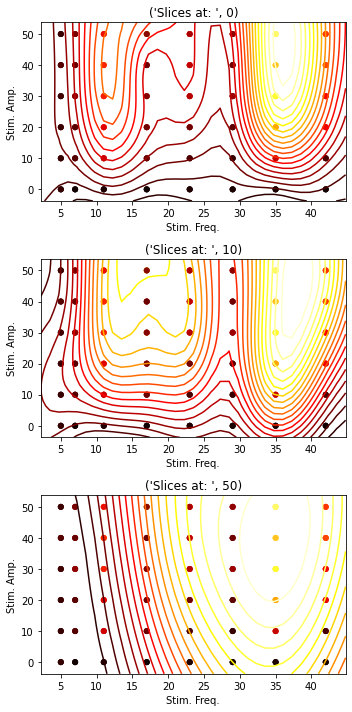

In [45]:
U1_X0, y, trained_model = model.initialize_data_dr_sim(U1_X0, X0_psd, X1, kernel_SDBO, slice_dim_SDBO, ylabel_SDBO)
# print(x)

In [46]:
testX = np.array([sampling_freq, sampling_amp, hill_sum_preStim_gamma])
print(np.shape(testX))
testX = np.transpose(testX)
# print(testX[:,0:3])

(3, 100)


In [47]:
state_est_SDBO = np.empty((100, 30))
simY_SDBO = np.empty((100, 30))
simMse_SDBO = np.empty((100, 30))

for j in range(30):
    state_est_SDBO[:, j], simY_SDBO[:, j:j+1], simMse_SDBO[:, j:j+1] = model.sample(testX, trained_model);

posteriorTestY_SDBO, simY_SDBO, simMse_SDBO = model.sample(testX, trained_model)

In [48]:
state_est_SDBO = np.empty((100, 30))
simY_SDBO = np.empty((100, 30))
simMse_SDBO = np.empty((100, 30))

for j in range(30):
    state_est_SDBO[:, j], simY_SDBO[:, j:j+1], simMse_SDBO[:, j:j+1] = model.sample(testX, trained_model);

In [49]:
print("mean is: \n",simY_SDBO[0,0],"\n\n Variance is: \n", simMse_SDBO[0, 0])
print(np.shape(state_est_SDBO),'\n',state_est_SDBO[0:10, 0])
print(np.shape(simY_SDBO),'\n', np.shape(simMse_SDBO))

mean is: 
 39.48027164844734 

 Variance is: 
 15.999478701704465
(100, 30) 
 [40.21247294 39.45244469 37.99838066 37.97858515 40.27413921 35.8805191
 39.89499402 41.87709975 39.66505876 34.29792956]
(100, 30) 
 (100, 30)


In [50]:
hill_state_est_SDBO = np.empty((100,30))
min_state_est_SDBO = np.min(state_est_SDBO, axis=0)
max_state_est_SDBO = np.max(state_est_SDBO, axis=0)
# step_size = (max_posteriorTestY_SDBO-min_posteriorTestY_SDBO)/50
for i in range(30):
    hill_state_est_SDBO[0:50, i] = np.linspace(min_state_est_SDBO[i], max_state_est_SDBO[i], 50)
    hill_state_est_SDBO[50:100, i] = np.linspace(max_state_est_SDBO[i],min_state_est_SDBO[i], 50)
print(hill_state_est_SDBO[0:3, 0])

[31.95435361 32.24620218 32.53805075]


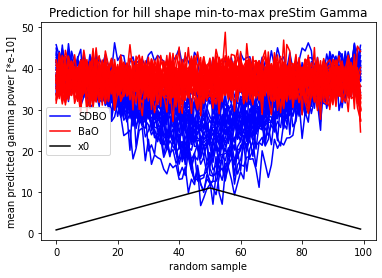

In [51]:
# plt.plot(posteriorTestY)
fig, ax = plt.subplots()
A = ax.plot(state_est_SDBO, 'b-', label='SDBO')
# plt.legend(['SDBO'])
B = ax.plot(state_est_BaO, 'r-', label='BaO')
# plt.legend(['BaO'])
# plt.plot(simY_SDBO[:, 0], 'b-')
# plt.plot(simY_SDBO[:, 0] + simMse_SDBO[:, 0]** 0.5, 'c--')
# plt.plot(simY_SDBO[:, 0] - simMse_SDBO[:, 0]** 0.5, 'c--')
C = ax.plot(hill_sum_preStim_gamma, 'k-', label='X0')
plt.ylabel('mean predicted gamma power [*e-10]')
plt.xlabel('random sample')
plt.title('Prediction for hill shape min-to-max preStim Gamma')
ax.legend([A[0], B[0], C[0]], ['SDBO', 'BaO', 'x0'])# 'Mean','+MSE', '-MSE', 
plt.show()

### Acquisition Function draft
function [X_samples, Y_samples, X_optimal_est, Y_optimal_est, Y_ground_truth] =  ...
    bayes_opt_on_state_dr_model(objective_model, input_space, n_samples, n_burn_in, acquisition_function, acq_params, measurement_function)


X_samples       = nan(n_samples, size(input_space,2));
X_optimal_est   = nan(n_samples, size(input_space,2));

Y_samples       = nan(n_samples, 1);
Y_optimal_est   = nan(n_samples, 1);
Y_ground_truth  = nan(n_samples, 1);

objective_est   = gp_object(); % GP model used in BaO 
burn_in_idx     = randi(size(input_space,1), n_burn_in,1);

objective_model.set_initial_state(); % Ground Truth simulation model 

for c1 = 1:n_samples
    
    if c1 <= n_burn_in
        X_samples(c1,:)     = input_space(burn_in_idx(c1),:);
    else
        X_samples(c1,:)     = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, c1);
    end
    
    Y_samples(c1,1)         = objective_model.sample(X_samples(c1,:));
    
    if c1 > 1    
        objective_est.initialize_data(X_samples(1:c1,:), Y_samples(1:c1)) % Exclude NaN when initializing GP

        [X_optimal_est(c1,:), Y_optimal_est(c1,:)] ...
            = objective_est.discrete_extrema(input_space);

        Y_ground_truth(c1)  = objective_model.predict_state(X_optimal_est(c1,:));
    end
    objective_model.transition_state();
end

end


#### Next make the bayes_opt_update_state_dr()
function X_new_sample = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, t)

[Y_mean, ~, ~, Y_uncertainty] = objective_est.predict(input_space);

switch acquisition_function
    case 'PI'
        acq_value = predicted_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'EI'
        acq_value = expected_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'UCB'
        acq_value = upper_confidence_bound(Y_mean, Y_uncertainty, acq_params, t);
end

[~, max_idx] = max(acq_value);

X_new_sample = input_space(max_idx,:);

end

##### the actual acquisition function is: upper_confidence_bound()

function ucb = upper_confidence_bound(Y_mean, Y_uncertainty, nu, t)

beta   	= 2 * log(t.^2*pi^2/(6));
ucb     = Y_mean + sqrt(nu*beta) * Y_uncertainty;

end

In [52]:
nu = 0.1
# t = the sample we are on 
